**Carupah - CarupAI - Natural Language Processing** 

In [2]:
#Import Libraries and Packages Needed
import tensorflow as tf
import numpy as np
import nltk
import json
import pickle
import random
import requests
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from nltk.stem import WordNetLemmatizer
from keras.callbacks import EarlyStopping

nltk.download('punkt') #Tokenizer
nltk.download('wordnet') #Lemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Get Dataset from Gdrive**

In [3]:
#Where file JSON is Stored
url = 'https://drive.google.com/uc?id=1-MClkBk3glO-MBTa3xQUD9QqVGIQqveo'
response = requests.get(url)
chatbot_json = response.content

In [4]:
chatbot_dataset = json.loads(chatbot_json) #Read file

In [5]:
print(json.dumps(chatbot_dataset, indent=2)) #See data

{
  "intents": [
    {
      "tag": "greeting",
      "patterns": [
        "Hi",
        "Hello",
        "Hallo",
        "Hey",
        "Mau tanya",
        "Hai, Welcome",
        "Ingin bertanya"
      ],
      "responses": [
        "Hello, Kamu mau bertanya?",
        "Hai, Selamat datang. Ada yang mau kamu tanyakan?",
        "Hi, kamu punya pertanyaan apa?",
        "Ada yang bisa CarupAI bantu?"
      ],
      "context": [
        ""
      ]
    },
    {
      "tag": "goodbye",
      "patterns": [
        "Bye",
        "Sampai jumpa lagi",
        "Okay, bye",
        "Senang berbicara dengan CarupAI, bye"
      ],
      "responses": [
        "Sampai jumpa!.Jangan lupa kelola sampah kamu ya :)",
        "Okay bye. Jangan lupa kelola sampah kamu ya :)",
        "Bye!.Jangan lupa kelola sampah kamu ya :)"
      ],
      "context": [
        ""
      ]
    },
    {
      "tag": "thanks",
      "patterns": [
        "Terima kasih",
        "Thank you",
        "Thanks",
       

In [6]:
# Decode the byte content to string
chatbot_json_str = chatbot_json.decode('utf-8')

# Load the JSON data
chatbot_json = json.loads(chatbot_json_str)

**Tokenization and Lemmatization**

In [7]:
#Variables
words=[]
classes=[]
documents=[]
ignore_sign=["!","?"]

In [8]:
for intent in chatbot_dataset['intents']:
  for pattern in intent['patterns']:

    #Tokenization
    word = nltk.word_tokenize(pattern)
    words.extend(word)
    documents.append((word, intent['tag'])) #each word to document, related with tag

    #add tag to classes 
    if intent['tag'] not in classes:
       classes.append(intent['tag'])

In [9]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_sign]

#Delete duplicates and sort
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))

print (len(words), "lemmatized words", words) #uniqe words
print (len(classes), "classes", classes) #tags
print (len(documents), "documents") 

108 lemmatized words [',', 'ada', 'adalah', 'air', 'aja', 'aluminium', 'anorganik', 'apa', 'bagaimana', 'bagamana', 'bantuan', 'berbicara', 'berikan', 'bertanya', 'buang', 'bye', 'cara', 'carupah', 'carupai', 'contoh', 'dampak', 'dan', 'dapat', 'daur', 'dengan', 'detergen', 'disposal', 'dong', 'efek', 'elektronik', 'hai', 'hallo', 'hasil', 'hdpe', 'hello', 'hey', 'hi', 'ingin', 'itu', 'jelasin', 'jelaskan', 'jenis', 'jenis-jenis', 'jumpa', 'kaca', 'kamu', 'kardus', 'kasih', 'kategori', 'kenapa', 'ketegori', 'keunggulan', 'kompos', 'lagi', 'lakukan', 'limbah', 'manfaat', 'mau', 'memanfaatkan', 'membantu', 'membantuku', 'membuang', 'membuat', 'memisahkan', 'mengatasi', 'mengelola', 'menggunakan', 'okay', 'organik', 'penanganan', 'pengelolaan', 'pengertian', 'penggunaan', 'pengomposaan', 'pengunaan', 'penjelasan', 'penting', 'pentingnya', 'plastik', 'produk', 'recycle', 'reduce', 'reuse', 'saja', 'sampah', 'sampai', 'sangat', 'sebut', 'sebutkan', 'senang', 'siapa', 'sih', 'styrofoam', 'su

**Save Variables and Create Training data**

In [10]:
#Saved python object to binner file
pickle.dump(words, open('data_words.pkl','wb'))
pickle.dump(classes, open('data_classes.pkl','wb'))

In [11]:
#Create Training Data

training = [] #create training data
output_empty = [0] * len(classes) #store the output labels corresponding to each pattern.

# Bag of Words
for document in documents:
    bag = [] #save bag of words
    pattern_words = document[0] #Get words from pattern
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words] #lemmatize each word

    #If the current word is in the sentence pattern
    '''
    for word in words:
        if word in pattern_words:
            bag.append(1) #it adds the number 1 to the bag
        else:
            bag.append(0) #Otherwise, it adds a 0.
    '''
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    output_row = list(output_empty) #list is initially initialized with all elements=0
    output_row[classes.index(document[1])] = 1 #If corresponds to the class index will be set to 1, while the other elements remain 0.
    training.append([bag, output_row]) #add to training list as training data

random.shuffle(training) #Randomize the order of training data.
training = np.array(training, dtype=object) #Convert the training list into a NumPy array.
#training = np.array(training)
train_x = list(training[:,0]) #contains sentence patterns from the training data.
train_y = list(training[:,1]) #contains output labels that match the sentence patterns from the training data.

**Create Neural Network Model for Natural Language Processing**

In [62]:
# Create model 
model = Sequential([
    Dense(256, input_shape=(len(train_x[0]),), activation='relu'), #First Layer 
    Dropout(0.5),
    Dense(128, activation='relu'), #Second Layer
    Dropout(0.5),
    Dense(len(train_y[0]), activation='softmax') #Output Layer
])


sgd = SGD(learning_rate=0.01, 
          decay=1e-6, 
          momentum=0.9, 
          nesterov=True
          )

model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy']
              )

'''

#Compile model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=['accuracy']
    )
'''


"\n\n#Compile model\nmodel.compile(\n    loss='categorical_crossentropy', \n    optimizer=Adam(learning_rate=0.0001), \n    metrics=['accuracy']\n    )\n"

**Model Summary**

In [63]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               27904     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 44)                5676      
                                                                 
Total params: 66,476
Trainable params: 66,476
Non-trainable params: 0
_________________________________________________________________


**Train Model**

In [57]:
#early_stopping = EarlyStopping(monitor='accuracy', patience=20)

In [64]:
#Training
history = model.fit(np.array(train_x), 
                    np.array(train_y), 
                    epochs=100, 
                    batch_size=5, 
                    verbose=1
                    #callbacks=[early_stopping]
                    )

Epoch 1/100
49/49 [==============================] - 1s 2ms/step - loss: 3.8038 - accuracy: 0.0207
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 3.6922 - accuracy: 0.0996
Epoch 3/100
49/49 [==============================] - 0s 2ms/step - loss: 3.5198 - accuracy: 0.1286
Epoch 4/100
49/49 [==============================] - 0s 2ms/step - loss: 3.2553 - accuracy: 0.1535
Epoch 5/100
49/49 [==============================] - 0s 2ms/step - loss: 2.9172 - accuracy: 0.2656
Epoch 6/100
49/49 [==============================] - 0s 2ms/step - loss: 2.5151 - accuracy: 0.3195
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 2.1931 - accuracy: 0.3983
Epoch 8/100
49/49 [==============================] - 0s 3ms/step - loss: 1.8506 - accuracy: 0.4772
Epoch 9/100
49/49 [==============================] - 0s 2ms/step - loss: 1.6040 - accuracy: 0.5228
Epoch 10/100
49/49 [==============================] - 0s 2ms/step - loss: 1.4446 - accuracy: 0.6100
Epoch 11/

**Loss and Accuracy Visualization Graph**

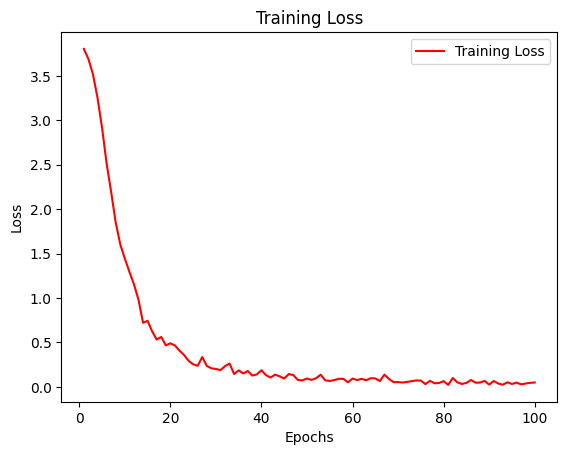

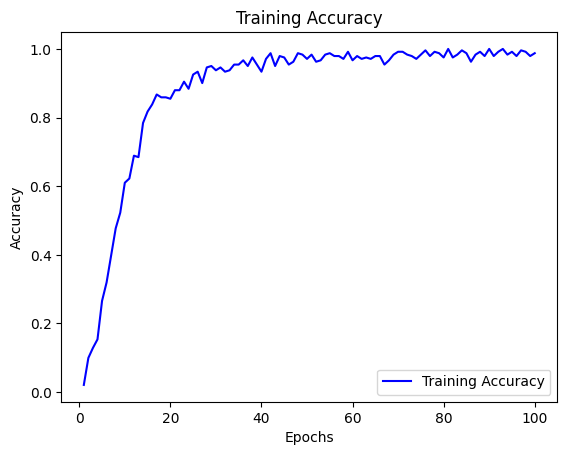

In [65]:
# Retrieve loss and accuracy data from history
loss = history.history['loss']
accuracy = history.history['accuracy']

# Taking the number of epochs
epochs = range(1, len(loss) + 1)

# Plot loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Save Model**

In [66]:
#savedmodel
model.save('chatbot_model.h5', history)

**Load Sources**

In [67]:
# Load intents data
intents = chatbot_json

# Load words and classes
words = pickle.load(open('data_words.pkl', 'rb'))
classes = pickle.load(open('data_classes.pkl', 'rb'))

# Load model
model = load_model('chatbot_model.h5')

**Testing Preparation**

In [68]:
#cleaning input sentences
def clean_sentence(sentence):
    words_in_sentence = nltk.word_tokenize(sentence) #Tokenization: words to array
    words_in_sentence = [lemmatizer.lemmatize(word.lower()) for word in words_in_sentence] #Lemmatization: turns words into base forms
    return words_in_sentence

In [69]:
#bag of words from sentence
def bow(sentence, words, show_details=True):
    words_in_sentence = clean_sentence(sentence) # Clean sentence input
    bag = [0]*len(words) #create list bag that will be used as the bag-of-words vector representation.
    for word in words_in_sentence:
        for i, word in enumerate(words):
            bag[i] = 1 if word == sentence else bag[i] #indicates that the word is in the input sentence
            if show_details:
                print("found in bag: %s" % word)
                
    #Returns a bag-of-words vector representation in the form of a numpy array.
    return(np.array(bag)) 

In [70]:
#Intent class prediction based on input sentences using the trained model
def predict_classes(sentence, model):

    # converts input sentences into bag of words vectors as input for the model.
    prediction = bow(sentence, words,show_details=False)
    #Using the model to make predictions on bag-of-words vectors
    result = model.predict(np.array([prediction]))[0] 

    #Filter the prediction results based on the error threshold.
    error_threshold = 0.25
    results = [[i,r] for i,r in enumerate(result) if r>error_threshold]
    
    results.sort(key=lambda x: x[1], reverse=True) #Sort the prediction results based on probability strength (in descending order).
    return_list = [] #Intents (classes)
    for r in results:
        return_list.append({"intent": classes[r[0]], #retrieves the class (intent) from the class index stored in results 
                            "probability": str(r[1]) #converts probabilities to strings before saving
                            }
                           )
    return return_list

In [71]:
#Get the appropriate response based on the intent predicted by the model.
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json
    for i in list_of_intents:
        if i["tag"] == tag: #Checks current tag intent matches the predicted tag.
            result = random.choice(i['responses'])
            break
    return result


In [72]:
#Get chatbot response based on model
def chatbot_response(text):
    ints = predict_classes(text, model)
    response = getResponse(ints, intents)
    return response

**TESTING**

In [73]:
#Chatbot Flow
flag = True
print('Hai, Aku CarupAI. Aku akan membantu kamu menjawab pertanyaan tentang sampah. Boleh langsung tanya aja ya')

while flag:
    newMessage = input("")
    
    if newMessage.lower() == "end":
        flag = False
        print('CarupAI: Sampai jumpa, jangan lupa kelola sampah kamu ya!')
    else:
        intents = predict_classes(newMessage, model)
        res = getResponse(intents, chatbot_json['intents'])
        print(res)


Hai, Aku CarupAI. Aku akan membantu kamu menjawab pertanyaan tentang sampah. Boleh langsung tanya aja ya
hai
1/1 [==============================] - 0s 71ms/step
Hai, Selamat datang. Ada yang mau kamu tanyakan?
hallo gkgkgk
1/1 [==============================] - 0s 23ms/step
Hi, kamu punya pertanyaan apa?
apa itu sampah?
1/1 [==============================] - 0s 36ms/step
Hai, Selamat datang. Ada yang mau kamu tanyakan?
sampah
1/1 [==============================] - 0s 23ms/step
Sampah adalah segala jenis material atau zat yang dihasilkan oleh manusia atau alam yang dianggap tidak berguna, tidak diinginkan, atau tidak diperlukan lagi. Sampah bisa berupa sisa-sisa makanan, kertas, plastik, logam, kaca, kain, limbah organik, dan bahan-bahan lainnya. Sampah juga dapat mencakup material yang dapat merusak lingkungan seperti baterai, bahan kimia berbahaya, atau limbah medis.
sampah elektronik
1/1 [==============================] - 0s 36ms/step
Hi, kamu punya pertanyaan apa?
apa itu sampah kac

In [311]:
'''
flag = True
print('Hai, Aku CarupAI. Aku akan membantu kamu menjawab pertanyaan tentang sampah. Boleh langsung tanya aja ya')

while flag:
    newMessage = input("")

    if newMessage.lower() == "end":
        flag = False
        print('CarupAI: Sampai jumpa, jangan lupa kelola sampah kamu ya!')
    else:
        intents = predict_classes(newMessage, model)

        if not intents:  # Menangani kasus jika intents kosong
            print("CarupAI: Maaf, aku tidak dapat memahami pertanyaanmu. Silakan coba pertanyaan lain.")
        else:
            res = getResponse(intents, chatbot_json['intents'])
            print(res)
'''

Hai, Aku CarupAI. Aku akan membantu kamu menjawab pertanyaan tentang sampah. Boleh langsung tanya aja ya
hai
1/1 [==============================] - 0s 25ms/step
Hello, Kamu mau bertanya?
hai hjhjhj
1/1 [==============================] - 0s 25ms/step
CarupAI: Maaf, aku tidak dapat memahami pertanyaanmu. Silakan coba pertanyaan lain.
hai
1/1 [==============================] - 0s 26ms/step
Hello, Kamu mau bertanya?
apa itu sampah plastik
1/1 [==============================] - 0s 25ms/step
CarupAI: Maaf, aku tidak dapat memahami pertanyaanmu. Silakan coba pertanyaan lain.
end
CarupAI: Sampai jumpa, jangan lupa kelola sampah kamu ya!
